# Importing Data

In [1]:
#data
import numpy as np 
import pandas as pd 

#viz
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import normaltest
import seaborn as sns

#machine learning and processing
from sklearn import preprocessing
from scipy.stats import skew, boxcox
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import optuna

#cross validation
from sklearn.model_selection import cross_val_predict, cross_val_score,KFold, cross_validate

#metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
data = [df_train, df_test]

In [3]:
df_train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

# Dealing With Nulls

In [4]:
print(df_train.isnull().sum()[df_train.isnull().sum() > 0])

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


From the data description, we can decide what to do with the null data for each feature.

**LotFrontage** is the lenght of the house that faces the street. That means we can't have a house with zero LotFrontage. Our solution will be to attribute random values to it, based on the mean and std, since the data is approximately normally distributed.

**Alley**, **Bsmt**,**FireplaceQu**, **Garage**, **PoolQC**, **Fence** when null means that there's access to alley, garage, firepalce, etc. 
For categorical features related to them, we can transform the column into ordinal categoric and atribuite a value as zero. But for numerical values, some cases we can not transform it into zeros, because that would misslead our model. That's why for **GarageYrBlt** we are going to transform it into the median, in a tentative to minimize the impact in our model.  Besides that, let's create another binary feature for the existence of garage, basement, pool and fence. For Fire place there's no necessity because there's a feature called number of fire places

**MasVnrType** there's no explanation for null values in the dictionary. Let's assume that the nulls means there's no masonry. **MasVnrArea** will be zero when null.

**MiscFeature** is a feature which was not convert into another categorical. Since there are just handful of rows that are not null, we are going to drop it.

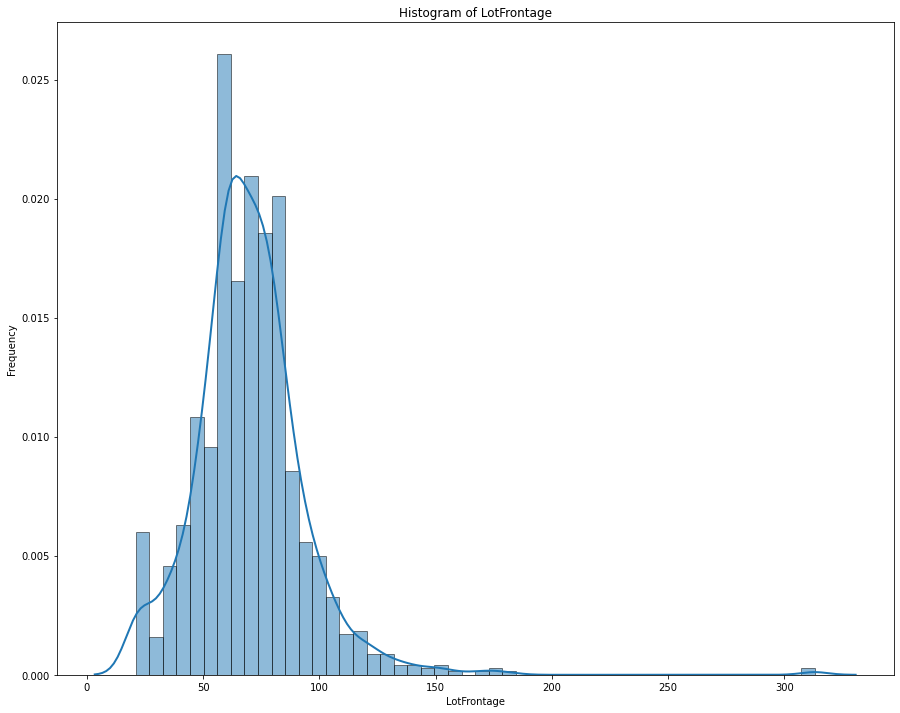

In [5]:
plt.figure(figsize=(15, 12))

sns.distplot(df_train['LotFrontage'], hist=True, kde=True,
             kde_kws={'linewidth': 2},
             hist_kws={'edgecolor': 'black', 'alpha': 0.5},
             fit_kws={'color': 'red', 'linewidth': 2})

plt.xlabel('LotFrontage')
plt.ylabel('Frequency')
plt.title('Histogram of LotFrontage')

plt.show()

In [6]:
# Test if the 'Age' column is normally distributed
p_value = normaltest(df_train['LotFrontage'])[1]

print('The null hypothesis is that the data is nomally distributed\n')

if p_value < 0.05:
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

The null hypothesis is that the data is nomally distributed

The null hypothesis cannot be rejected


In [7]:
mean_lot = df_train['LotFrontage'].mean()
std_lot = df_train['LotFrontage'].std()

for dataset in data:
    is_null = dataset['LotFrontage'].isnull().sum() #number of nulls
    rand_lot = np.random.randint(mean_lot - std_lot, mean_lot + std_lot, size = is_null) #create numpy array with random values
    
    #fill nulls with random values created
    lot_slice = dataset["LotFrontage"].copy()
    lot_slice[np.isnan(lot_slice)] = rand_lot
    dataset["LotFrontage"] = lot_slice

In [8]:
for dataset in data:
    dataset['GarageYrBlt'].fillna(df_train['GarageYrBlt'].median(), inplace=True)
    dataset['MasVnrType'].fillna('None', inplace=True)
    dataset['MasVnrArea'].fillna(0, inplace=True)

In [9]:
for dataset in data:
    dataset['HasGarage'] = dataset['GarageType'].apply(lambda x: 0 if pd.isna(x) else 1)
    dataset['HasBsmt'] = dataset['BsmtQual'].apply(lambda x: 0 if pd.isna(x) else 1)
    dataset['HasPool'] = dataset['PoolQC'].apply(lambda x: 0 if pd.isna(x) else 1)
    dataset['HasFence'] = dataset['Fence'].apply(lambda x: 0 if pd.isna(x) else 1)

In [10]:
dataset[['GarageType','HasGarage']]

GarageType  HasGarage
0        Attchd          1
1        Attchd          1
2        Attchd          1
3        Attchd          1
4        Attchd          1
...         ...        ...
1454        NaN          0
1455    CarPort          1
1456     Detchd          1
1457        NaN          0
1458     Attchd          1

[1459 rows x 2 columns]

In [11]:
for dataset in data:
    dataset.drop('MiscFeature',axis =1 , inplace=True)

In [12]:
print(df_train.isnull().sum()[df_train.isnull().sum() > 0])

Alley           1369
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
dtype: int64


We are still missing some columns with null values. Since these are all categorical features, we are going to either one hot encode it or transform it into ordinal. When transforming it into ordinal, we need to be careful with the order of it. For example, the feature PoolQC (quality) there're excellent, good, average and fair categories. So when transforming it into ordinal, we can make it 4,3,2,1 for example. Since null means no Pool, we should make it 0, since having a fair pool is better no pool at all. The replacement of the value should respect this order, because some algorithms such as linear will be mislead in case the Null would has in the wrong position of quality. Notice that in case Excellent were 1, having no Pool being 0 would not represent the real business value of that feature.
We will do that soon, keep that in mind when we transform the categorical data into numbers.

# Matrix of Correlation

With the Matrix of Correlation we can see how the features are correlated with each other. Why do we want to analyse it? To avoid ambiguity

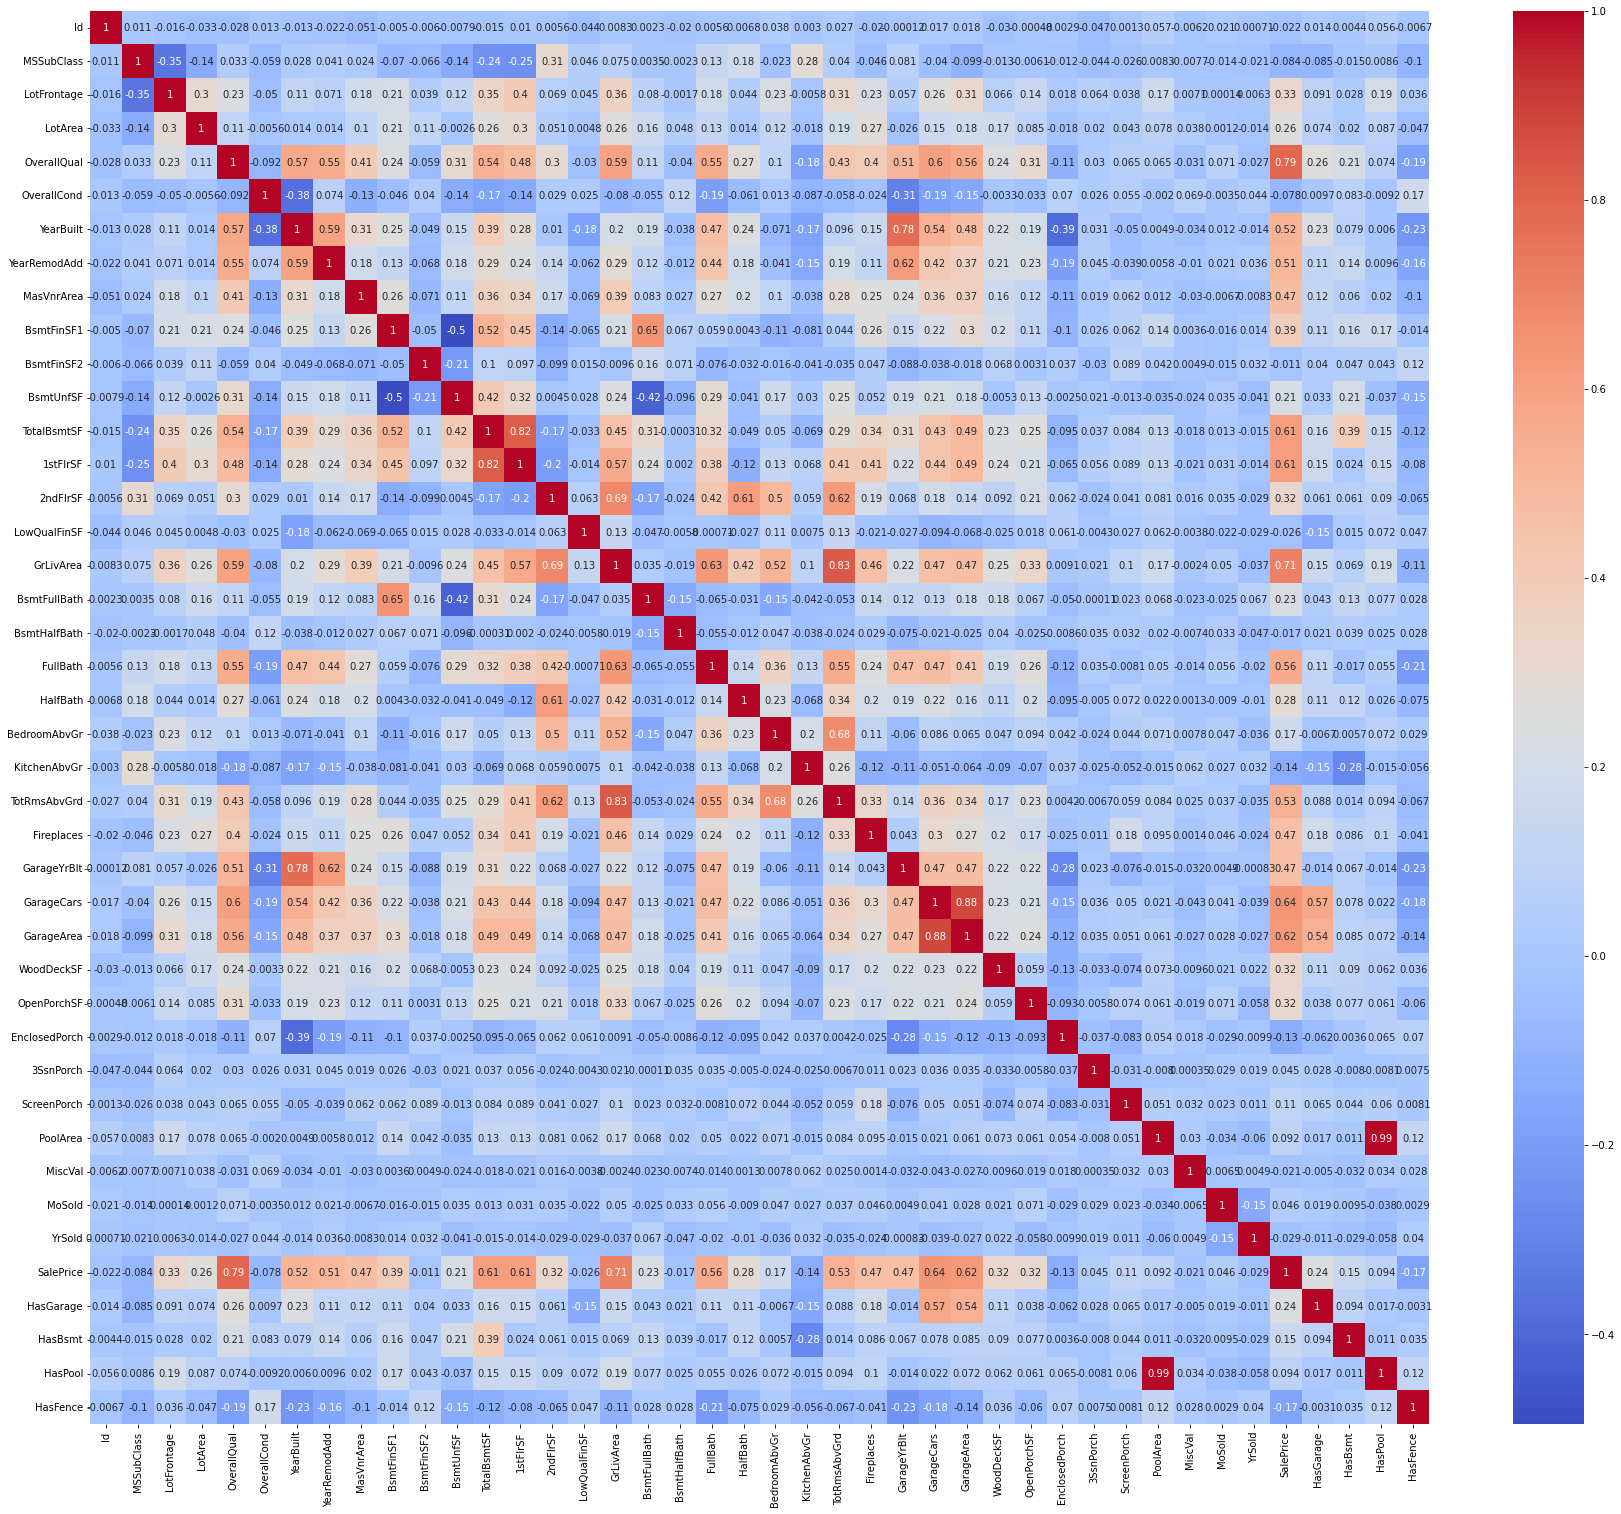

In [13]:
corr_matrix = df_train.corr()
plt.figure(figsize=(30, 26))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [14]:
#print top and bottom 10 correlation
pairs = corr_matrix.unstack().sort_values(ascending=False).drop_duplicates()
top_corr = pairs[pairs != 1][:10]
bottom_corr = pairs[-10:]

print('Top 5: ')
print(top_corr)
print('\n***********\n')
print('Bottom 5: ')
print(bottom_corr)

Top 5: 
HasPool       PoolArea        0.989665
GarageArea    GarageCars      0.882475
TotRmsAbvGrd  GrLivArea       0.825489
1stFlrSF      TotalBsmtSF     0.819530
SalePrice     OverallQual     0.790982
YearBuilt     GarageYrBlt     0.777182
SalePrice     GrLivArea       0.708624
2ndFlrSF      GrLivArea       0.687501
BedroomAbvGr  TotRmsAbvGrd    0.676620
BsmtFullBath  BsmtFinSF1      0.649212
dtype: float64

***********

Bottom 5: 
TotalBsmtSF   MSSubClass      -0.238518
1stFlrSF      MSSubClass      -0.251758
KitchenAbvGr  HasBsmt         -0.282478
GarageYrBlt   EnclosedPorch   -0.284972
OverallCond   GarageYrBlt     -0.306276
LotFrontage   MSSubClass      -0.354120
OverallCond   YearBuilt       -0.375983
YearBuilt     EnclosedPorch   -0.387268
BsmtFullBath  BsmtUnfSF       -0.422900
BsmtUnfSF     BsmtFinSF1      -0.495251
dtype: float64


By looking at the bottom 10 (feature correlates to the opposite of the other) we can see that's not much significance to it.
But the top 10 shows a high level of correlation. Let's check each case. 

The first example is analysed bellow. Note that most houses has no pool, just a handful of the houses have a pool. Therefore, for most of the data the two columns will be dupplicated. Since there's only 7 pools in an universe of 1460 houses in the training set, the size of the feature won't be much helful. As a matter of fact, most likely it'll damage our model because of the ambiguity. So let's drop the pool size feature.
The second relation is the number of cars with area. That makes total sense, the size will define how many cars fit on it. We'll drop one of them.
We won't drop one of the third pair, since they are imporant features and not necessarily means similar things. 
The fourth pair would not be appropriate to drop one, even though they are correlated, they do not quantify similar things. 
The fifth pair is about what we want to predict. We can see that OverallQual is a important feature to the price.
The year of the garage and the house was built make total sense to be similar, since usually the garage is built at the same time as the house. Therefore, we will drop the Garage Year.
We are going to keep rest since the correlation is bellow 0.70.Note that GrLivArea also play a big role in the price.


In [15]:
for dataset in data:
    dataset.drop(['PoolArea', 'GarageCars', 'GarageYrBlt'], axis=1, inplace=True)

# Exploratory Analyses

Now let's take a look at some of the features. So far we got 79 features, not the most easy one to analyse case by case. By look at the dictionary, I tried to analyse the ones I guessed was the most important for the real estate business. 

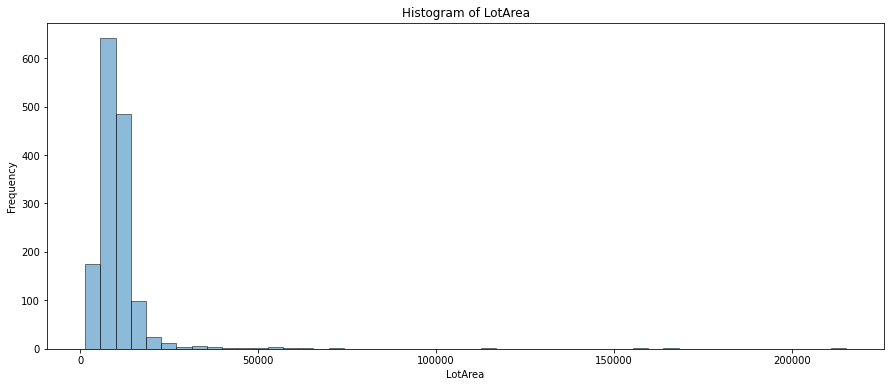

In [16]:
plt.figure(figsize=(15, 6))

sns.distplot(df_train['LotArea'], hist=True, kde=False,
             hist_kws={'edgecolor': 'black', 'alpha': 0.5},
             fit_kws={'color': 'red', 'linewidth': 2})

plt.xlabel('LotArea')
plt.ylabel('Frequency')
plt.title('Histogram of LotArea')

plt.show()

Note that most of the houses have sizes at similar area, but if you look really close to the screen (sorry about that) you'll see that there are just some houses wehere the size can get real bike. 
Let's compare that with the price and also add another feature, the quality.

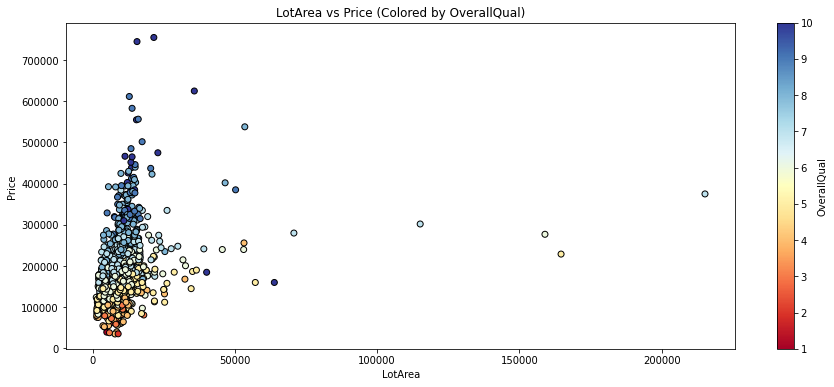

In [17]:
plt.figure(figsize=(15, 6))

cmap = plt.cm.get_cmap('RdYlBu')  

#normalizes OverallQual to the range [0, 1]
categories = np.unique(df_train['OverallQual'])
norm = plt.Normalize(np.min(categories), np.max(categories))  # Set the minimum and maximum values for 'OverallQual'

plt.scatter(df_train['LotArea'], df_train['SalePrice'], c=df_train['OverallQual'], cmap=cmap, norm=norm, edgecolor='black')

plt.xlabel('LotArea')
plt.ylabel('Price')
plt.title('LotArea vs Price (Colored by OverallQual)')

cbar = plt.colorbar(label='OverallQual')
cbar.set_ticks(range(np.min(categories), np.max(categories)+1))  #makes the bar matches with what we have in OverallQual
cbar.set_ticklabels(range(np.min(categories), np.max(categories)+1)) 

plt.show()

Note that the most expensive houses are not the biggest, but we can confirm what we've seen in the correlation section, the quality plays an important role in the prices.
Now let's take a look by neighborhood.

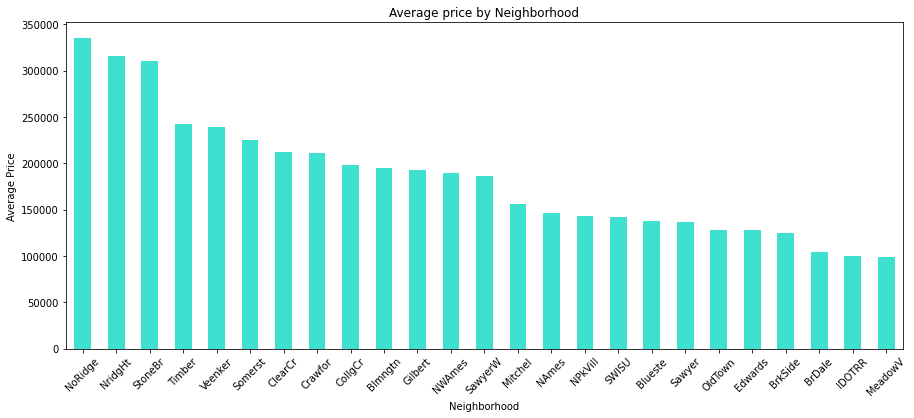

In [18]:
neighborhood_avg_price = df_train.groupby('Neighborhood')['SalePrice'].mean().sort_values(ascending = False) #avg price of the house in the neighborhood

plt.figure(figsize=(15, 6))

# Create the bar plot
neighborhood_avg_price.plot(kind='bar', color = 'turquoise')

# Set the labels and title
plt.xlabel('Neighborhood')
plt.ylabel('Average Price')
plt.title('Average price by Neighborhood')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.show()

What about the year the house was built?

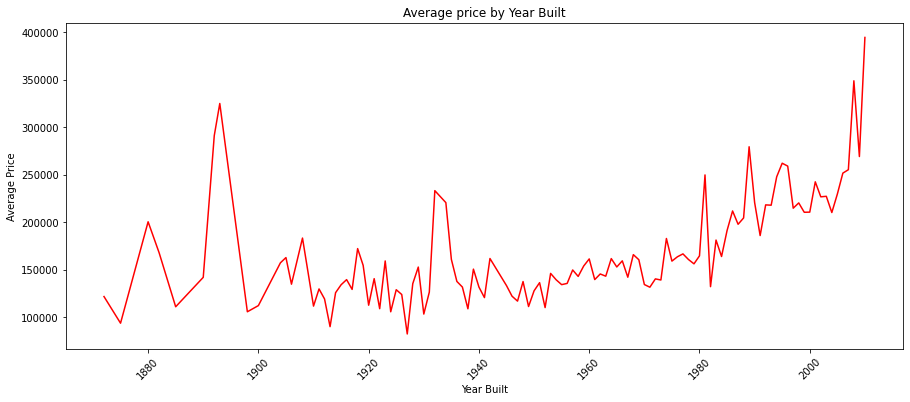

In [19]:
year_built_avg_price = df_train.groupby('YearBuilt')['SalePrice'].mean() #avg price of the house in the neighborhood

plt.figure(figsize=(15, 6))

# Create the bar plot
year_built_avg_price.plot(kind='line', color = 'red')

# Set the labels and title
plt.xlabel('Year Built')
plt.ylabel('Average Price')
plt.title('Average price by Year Built')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.show()

Can you see that there's a lot of noise in the data? That's beacuse for some year (especially the ones in the past) there's just some few cases for each year (some cases only one!). So that drives the avereage up and down. This may misslead our model. To avoid having just a few cases for each year, I'll combine than into clusters. For the most recent I'll divide that in decates. Before 1900, I'll group 20 year together. After 2010 we will group into 5 years groups, keep the brand new houses.

In [20]:
for dataset in data:
    dataset['YearBuiltDecades'] = [year//5*5  if year >= 2000 else year//10*10 if year >= 1900 else year//20*20 for year in dataset['YearBuilt']]

df_train[['YearBuilt','YearBuiltDecades']]

YearBuilt  YearBuiltDecades
0          2003              2000
1          1976              1970
2          2001              2000
3          1915              1910
4          2000              2000
...         ...               ...
1455       1999              1990
1456       1978              1970
1457       1941              1940
1458       1950              1950
1459       1965              1960

[1460 rows x 2 columns]

In [21]:
df_train.groupby('YearBuiltDecades')['YearBuiltDecades'].count().head(25)

YearBuiltDecades
1860      2
1880     13
1900     15
1910     58
1920     97
1930     54
1940     79
1950    167
1960    175
1970    188
1980     61
1990    163
2000    166
2005    221
2010      1
Name: YearBuiltDecades, dtype: int64

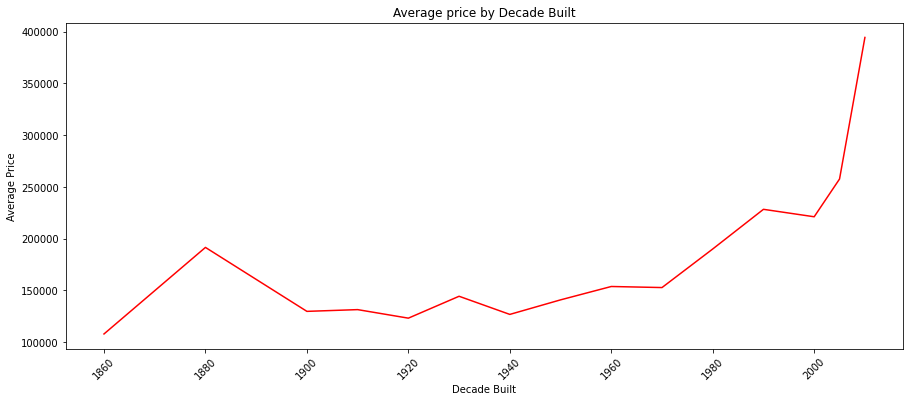

In [22]:
year_built_avg_price = df_train.groupby('YearBuiltDecades')['SalePrice'].mean() #avg price of the house in the neighborhood

plt.figure(figsize=(15, 6))

year_built_avg_price.plot(kind='line', color = 'red')

plt.xlabel('Decade Built')
plt.ylabel('Average Price')
plt.title('Average price by Decade Built')

plt.xticks(rotation=45)

plt.show()

**Now that makes more sense!!!**

In [23]:
for dataset in data:
    dataset.drop('YearBuilt',axis =1 , inplace=True)

We also have data related to the year and month the house was sold. If you think about it, this is the kind of feature we want to keep for two reason. First is the month. Maybe there's a correlation between the price and the period of the month. In some contries it's common to have a higher demand for houses in the begging of the year, because people start the year wanting some changes in life.
Now talking about the year, we can have an inflation relation here. It's important to remember that in 2008 we've had the housing bubble crises, dropping significantly the price of the houses. Let's take a look at the avegerage sold price along the years.

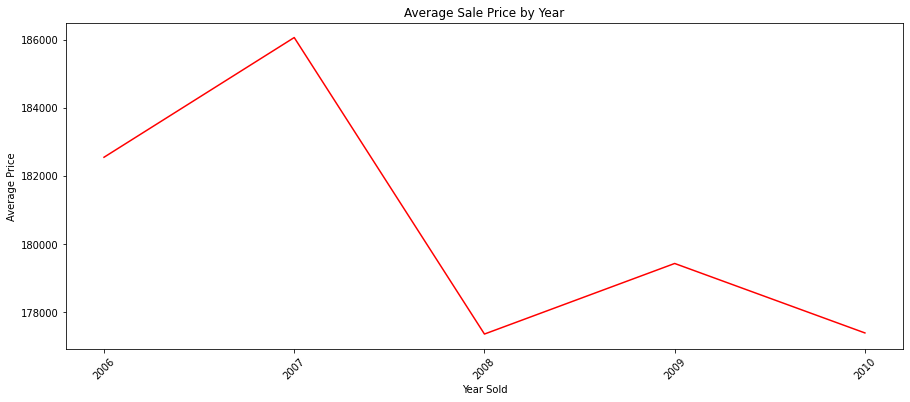

In [24]:
year_sale_avg_price = df_train.groupby('YrSold')['SalePrice'].mean() #avg price of the house in the neighborhood

plt.figure(figsize=(15, 6))

year_sale_avg_price.plot(kind='line', color = 'red')

plt.xlabel('Year Sold')
plt.ylabel('Average Price')
plt.title('Average Sale Price by Year')

plt.xticks(rotation=45)
plt.xticks(year_sale_avg_price.index.astype(int))  #avoids decimal number in the viz

plt.show()

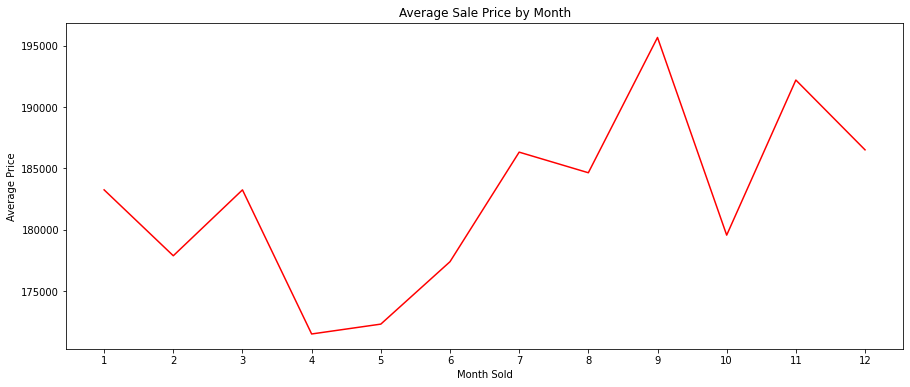

In [25]:
month_sale_avg_price = df_train.groupby('MoSold')['SalePrice'].mean() #avg price of the house in the neighborhood

plt.figure(figsize=(15, 6))

month_sale_avg_price.plot(kind='line', color = 'red')

plt.xlabel('Month Sold')
plt.ylabel('Average Price')
plt.title('Average Sale Price by Month')

plt.xticks(rotation=0)
plt.xticks(month_sale_avg_price.index) #display all months

plt.show()

That's what I've thought about 2008. Looking at the month effect, the avg price is high during the second half of the year. 

Now if you think about a model in real life to predict price, we would need to use an inflation ratio to account for the price variation along the years, because the price the model was trained had data from the past, but we are trying to predict current prices. However here we will use similar data we have in the train and test df to be evalueted. Thefore, let's leave this way.

The next features we will take a closer look is the style of dwelling and the zoning. Here is the legend for each of them:

HouseStyle:

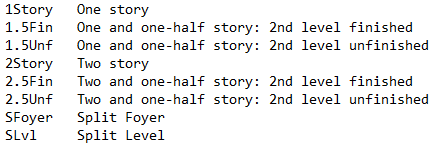

MSZoning:

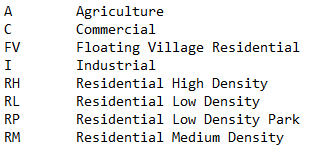

Text(0.5, 1.0, 'Box plot of Type of Dwelling vs Price')

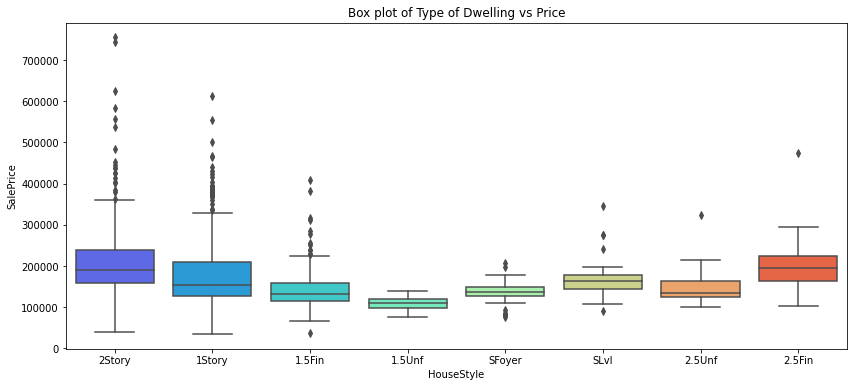

In [26]:
f = plt.figure(figsize=(14,6))

sns.boxplot(x='HouseStyle', y='SalePrice',data=df_train,palette='rainbow')
plt.title('Box plot of Type of Dwelling vs Price')

Note the number of outliers for 2 and 1 stories. Also note that the price for two stories houses tend to be higher.

Text(0.5, 1.0, 'Box plot of Type of Dwelling vs Price')

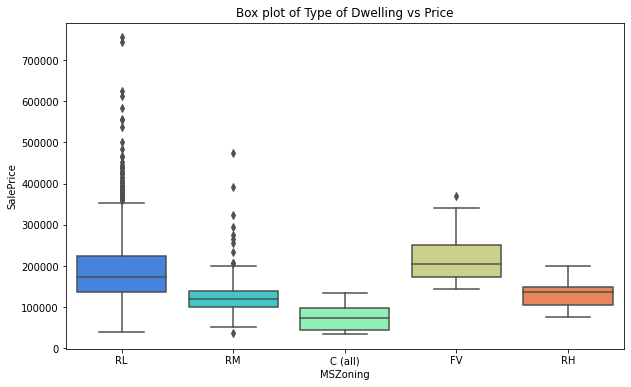

In [27]:
f = plt.figure(figsize=(10,6))

sns.boxplot(x='MSZoning', y='SalePrice',data=df_train,palette='rainbow')
plt.title('Box plot of Type of Dwelling vs Price')

In [28]:
df_train[['MSSubClass','HouseStyle']].drop_duplicates().sort_values(by = 'MSSubClass').head(15).style.hide_index()

Note that MSSubclass is related to HouseStyle. Also, MSSubclass is numerical, but there's not necessarily an order (higher/lower) is better. To avoid being misslead by this feature in the training, let's drop it since we are already using HouseStyle.

In [29]:
for dataset in data:
    dataset.drop('MSSubClass',axis =1 , inplace=True)

Let's check if there's any negative data, where we should not have it

In [30]:
#display true if the numeric feature has negatives
(df_train.select_dtypes(include=[np.number]) < 0).any()

Id                  False
LotFrontage         False
LotArea             False
OverallQual         False
OverallCond         False
YearRemodAdd        False
MasVnrArea          False
BsmtFinSF1          False
BsmtFinSF2          False
BsmtUnfSF           False
TotalBsmtSF         False
1stFlrSF            False
2ndFlrSF            False
LowQualFinSF        False
GrLivArea           False
BsmtFullBath        False
BsmtHalfBath        False
FullBath            False
HalfBath            False
BedroomAbvGr        False
KitchenAbvGr        False
TotRmsAbvGrd        False
Fireplaces          False
GarageArea          False
WoodDeckSF          False
OpenPorchSF         False
EnclosedPorch       False
3SsnPorch           False
ScreenPorch         False
MiscVal             False
MoSold              False
YrSold              False
SalePrice           False
HasGarage           False
HasBsmt             False
HasPool             False
HasFence            False
YearBuiltDecades    False
dtype: bool

In [31]:
(df_test.select_dtypes(include=[np.number]) < 0).any()

Id                  False
LotFrontage         False
LotArea             False
OverallQual         False
OverallCond         False
YearRemodAdd        False
MasVnrArea          False
BsmtFinSF1          False
BsmtFinSF2          False
BsmtUnfSF           False
TotalBsmtSF         False
1stFlrSF            False
2ndFlrSF            False
LowQualFinSF        False
GrLivArea           False
BsmtFullBath        False
BsmtHalfBath        False
FullBath            False
HalfBath            False
BedroomAbvGr        False
KitchenAbvGr        False
TotRmsAbvGrd        False
Fireplaces          False
GarageArea          False
WoodDeckSF          False
OpenPorchSF         False
EnclosedPorch       False
3SsnPorch           False
ScreenPorch         False
MiscVal             False
MoSold              False
YrSold              False
HasGarage           False
HasBsmt             False
HasPool             False
HasFence            False
YearBuiltDecades    False
dtype: bool

Now let's take a look if the Sale Price is normalized

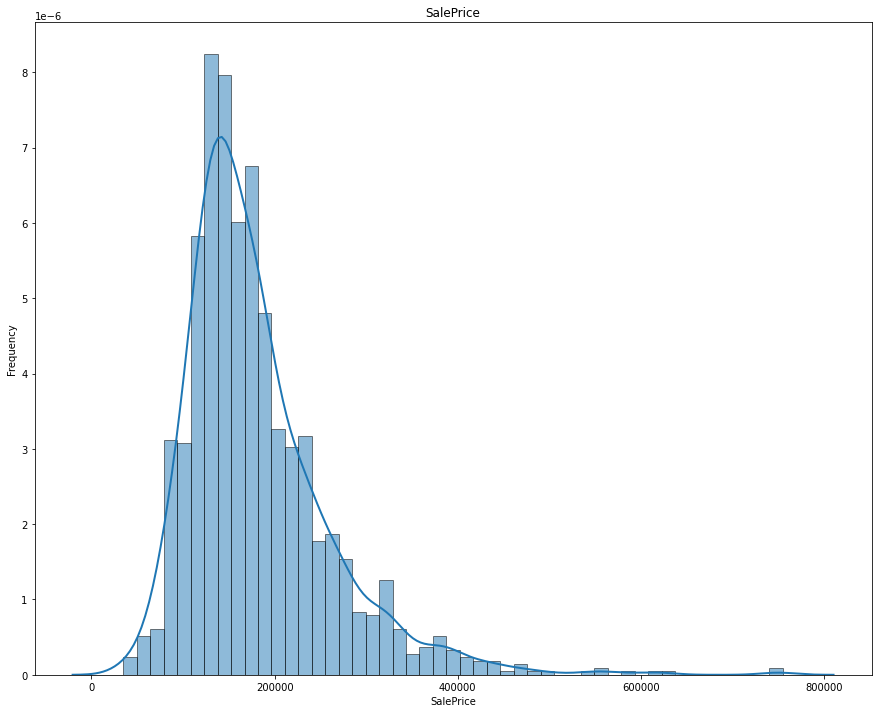

In [32]:
plt.figure(figsize=(15, 12))

sns.distplot(df_train['SalePrice'], hist=True, kde=True,
             kde_kws={'linewidth': 2},
             hist_kws={'edgecolor': 'black', 'alpha': 0.5},
             fit_kws={'color': 'red', 'linewidth': 2})

plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.title('SalePrice')

plt.show()

Let's normalize it

In [33]:
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

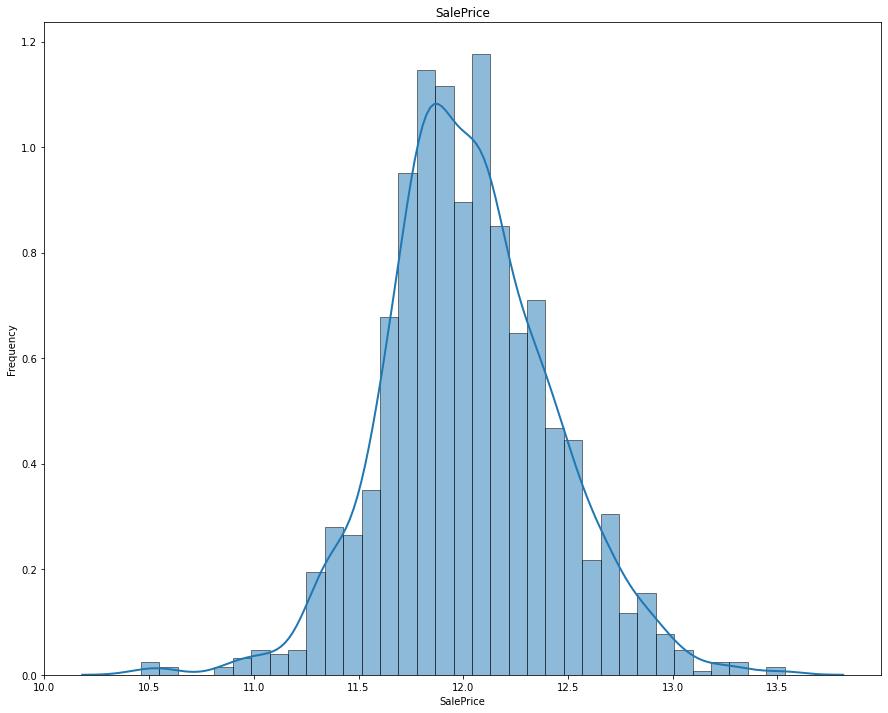

In [34]:
plt.figure(figsize=(15, 12))

sns.distplot(df_train['SalePrice'], hist=True, kde=True,
             kde_kws={'linewidth': 2},
             hist_kws={'edgecolor': 'black', 'alpha': 0.5},
             fit_kws={'color': 'red', 'linewidth': 2})

plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.title('SalePrice')

plt.show()

# Preprocessing the Data
Now it's necessary to make some changes in the dataset before we feed it into the models. Theses changes are: transforming categorical data into numerical and standandarzing the numerical data, because some model will behave poorely when to standardized. 

First let's see if there's any other feature that falls into that category we mentioned above, being numeric but not having an order.

In [35]:
df_train.select_dtypes(include='int64').columns

Index(['Id', 'LotArea', 'OverallQual', 'OverallCond', 'YearRemodAdd',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'MoSold',
       'YrSold', 'HasGarage', 'HasBsmt', 'HasPool', 'HasFence',
       'YearBuiltDecades'],
      dtype='object')

Apparently not, we just need to remember to remove the Id when training the data. Now let's take a look at the columns with type as string. 

In [36]:
df_train.select_dtypes(include='object').columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'SaleType',
       'SaleCondition'],
      dtype='object')

Here what is necessary to do is to check the features that has an oder. For those, we will assing the bigger value to the best category and go down to the worst, being 1. For the features that we can't see explicit an order, we will one hot encode. 
That's too much of work to be explained here one by one.

Bellow you can see the conclusions I by looking at the dictionary. Here I would like to highlight the importance of having a business knowlodge. I had a hard time to classify it, not knowing if a a foundation of Poured Contrete is better than Stone, for example.

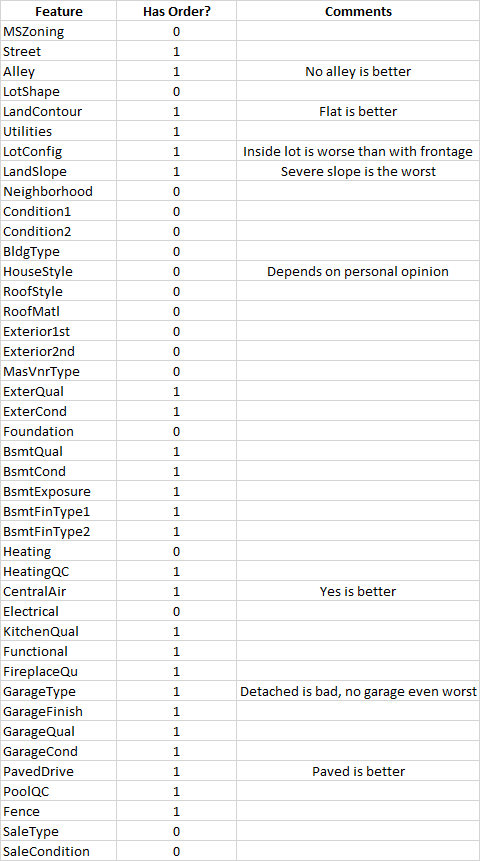

In [37]:
street_map = {None: 0, 'Pave': 1, 'Grvl': 2}
land_contour_map = {'Low': 1, 'HLS': 2, 'Bnk': 3, 'Lvl':4}
utilities_map = {None: 0, 'ELO': 1, 'NoSeWa': 2, 'NoSewr': 3, 'AllPub': 4}
lotconfig_map = {'Inside': 1, 'Corner': 2, 'CulDSac': 3, 'FR2': 4, 'FR3': 5}
landslope_map = {'Sev': 1, 'Mod': 2, 'Gtl': 3}
exterqual_map = {None: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
bsmtexposure_map = {None: 0,'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
bsmtfintype_map = {None: 0,'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
heatingQC_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
centralAir_map = {'N': 1, 'Y': 2}
functional_map = {'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 'Mod': 5, 'Min2': 6, 'Min1': 7, 'Typ': 8}
garage_type_map = {None: 0,'Detchd': 1, 'CarPort': 2, 'BuiltIn': 3, 'Basment': 3, 'Attchd': 3, '2Types': 4} #buint in, attached to home and basement garage has same weights
garage_finish_map = {None: 0,'Unf': 1, 'RFn': 2, 'Fin': 3}
paved_drive_map = {'N': 1,'P': 2,'Y': 3}
fence_map = {None: 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}

for dataset in data:
    dataset['Street'].replace(street_map, inplace = True)
    dataset['Alley'].replace(street_map, inplace = True) #same categories as Street
    dataset['LandContour'].replace(land_contour_map, inplace = True)
    dataset['Utilities'].replace(utilities_map, inplace = True)
    dataset['LotConfig'].replace(lotconfig_map, inplace = True)
    dataset['LandSlope'].replace(landslope_map, inplace = True)
    dataset['ExterQual'].replace(exterqual_map, inplace = True)
    dataset['ExterCond'].replace(exterqual_map, inplace = True) #same categories as ExterQual
    dataset['BsmtQual'].replace(exterqual_map, inplace = True) #same categories as ExterQual
    dataset['BsmtCond'].replace(exterqual_map, inplace = True) #same categories as ExterQual
    dataset['BsmtExposure'].replace(bsmtexposure_map, inplace = True)
    dataset['BsmtFinType1'].replace(bsmtfintype_map, inplace = True)
    dataset['BsmtFinType2'].replace(bsmtfintype_map, inplace = True)
    dataset['HeatingQC'].replace(heatingQC_map, inplace = True)
    dataset['CentralAir'].replace(centralAir_map, inplace = True)
    dataset['KitchenQual'].replace(heatingQC_map, inplace = True) #same categories as HeatingQC
    dataset['Functional'].replace(functional_map, inplace = True)
    dataset['FireplaceQu'].replace(exterqual_map, inplace = True) #same categories as ExterQual
    dataset['GarageType'].replace(garage_type_map, inplace = True)
    dataset['GarageFinish'].replace(garage_finish_map, inplace = True)
    dataset['GarageQual'].replace(exterqual_map, inplace = True) #same categories as ExterQual
    dataset['GarageCond'].replace(exterqual_map, inplace = True) #same categories as ExterQual
    dataset['PavedDrive'].replace(paved_drive_map, inplace = True)
    dataset['PoolQC'].replace(exterqual_map, inplace = True) #same categories as ExterQual, but without Po
    dataset['Fence'].replace(fence_map, inplace = True)

In [38]:
print(df_train.isnull().sum()[df_train.isnull().sum() > 0])

Electrical    1
dtype: int64


In [39]:
print(df_test.isnull().sum()[df_test.isnull().sum() > 0])

MSZoning        4
Exterior1st     1
Exterior2nd     1
BsmtFinSF1      1
BsmtFinSF2      1
BsmtUnfSF       1
TotalBsmtSF     1
BsmtFullBath    2
BsmtHalfBath    2
KitchenQual     1
Functional      2
GarageArea      1
SaleType        1
dtype: int64


We are still seing some nulls in the training and test set. Let's deal with it.

MSZoning is if the classification zone is agriculture, commercial, residencial. Let's replace the nulls with the most common value.
BsmtFullBath and BsmtHalfBath are the number of bathrooms in the basement. Let's use the mode (most common).
Functional, KitchenQual and Electrical we are going to use the most common as well.

For continuous numerical variables (BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF and GarageArea) let's use the median.

In [40]:
most_common_Electrical = df_train.groupby('Electrical')['Id'].count().sort_values(ascending = False).index[0]
most_common_MSZoning = df_train.groupby('MSZoning')['Id'].count().sort_values(ascending = False).index[0]
most_common_BsmtFullBath = df_train['BsmtFullBath'].mode().index[0]
most_common_BsmtHalfBath = df_train['BsmtHalfBath'].mode().index[0]
most_common_Function = df_train.groupby('Functional')['Id'].count().sort_values(ascending = False).index[0]
most_common_Kitchen = df_train.groupby('KitchenQual')['Id'].count().sort_values(ascending = False).index[0]

In [41]:
median_BsmtFinSF1, median_BsmtFinSF2, median_BsmtUnfSF, median_TotalBsmtSF, median_GarageArea = df_train[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']].median()

In [42]:
df_train['Electrical'].fillna(most_common_Electrical, inplace = True)
df_test['MSZoning'].fillna(most_common_MSZoning, inplace = True)
df_test['BsmtFullBath'].fillna(most_common_BsmtFullBath, inplace = True)
df_test['BsmtHalfBath'].fillna(most_common_BsmtHalfBath, inplace = True)
df_test['Functional'].fillna(most_common_Function, inplace = True)
df_test['KitchenQual'].fillna(most_common_Kitchen, inplace = True)

df_test['BsmtFinSF1'].fillna(median_BsmtFinSF1, inplace = True)
df_test['BsmtFinSF2'].fillna(median_BsmtFinSF2, inplace = True)
df_test['BsmtUnfSF'].fillna(median_BsmtUnfSF, inplace = True)
df_test['TotalBsmtSF'].fillna(median_TotalBsmtSF, inplace = True)
df_test['GarageArea'].fillna(median_GarageArea, inplace = True)

We've replaced the categorical data that has an order. Now let's one hot encode the rest.

In [43]:
non_ordinal_categorical = df_train.select_dtypes(include='object').columns
df_train[non_ordinal_categorical]

MSZoning LotShape Neighborhood Condition1 Condition2 BldgType HouseStyle  \
0          RL      Reg      CollgCr       Norm       Norm     1Fam     2Story   
1          RL      Reg      Veenker      Feedr       Norm     1Fam     1Story   
2          RL      IR1      CollgCr       Norm       Norm     1Fam     2Story   
3          RL      IR1      Crawfor       Norm       Norm     1Fam     2Story   
4          RL      IR1      NoRidge       Norm       Norm     1Fam     2Story   
...       ...      ...          ...        ...        ...      ...        ...   
1455       RL      Reg      Gilbert       Norm       Norm     1Fam     2Story   
1456       RL      Reg       NWAmes       Norm       Norm     1Fam     1Story   
1457       RL      Reg      Crawfor       Norm       Norm     1Fam     2Story   
1458       RL      Reg        NAmes       Norm       Norm     1Fam     1Story   
1459       RL      Reg      Edwards       Norm       Norm     1Fam     1Story   

     RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType Foundation Heating  \
0        Gable  CompShg     VinylSd     VinylSd    BrkFace      PConc    GasA   
1        Gable  CompShg     MetalSd     MetalSd       None     CBlock    GasA   
2        Gable  CompShg     VinylSd     VinylSd    BrkFace      PConc    GasA   
3        Gable  CompShg     Wd Sdng     Wd Shng       None     BrkTil    GasA   
4        Gable  CompShg     VinylSd     VinylSd    BrkFace      PConc    GasA   
...        ...      ...         ...         ...        ...        ...     ...   
1455     Gable  CompShg     VinylSd     VinylSd       None      PConc    GasA   
1456     Gable  CompShg     Plywood     Plywood      Stone     CBlock    GasA   
1457     Gable  CompShg     CemntBd     CmentBd       None      Stone    GasA   
1458       Hip  CompShg     MetalSd     MetalSd       None     CBlock    GasA   
1459     Gable  CompShg     HdBoard     HdBoard       None     CBlock    GasA   

     Electrical SaleType SaleCondition  
0         SBrkr       WD        Normal  
1         SBrkr       WD        Normal  
2         SBrkr       WD        Normal  
3         SBrkr       WD       Abnorml  
4         SBrkr       WD        Normal  
...         ...      ...           ...  
1455      SBrkr       WD        Normal  
1456      SBrkr       WD        Normal  
1457      SBrkr       WD        Normal  
1458      FuseA       WD        Normal  
1459      SBrkr       WD        Normal  

[1460 rows x 17 columns]

In [44]:
# this is step is necessary because if we don't combine both, the enconding would result in a different number of columns
# since the traing set do not all the categories for each columns, and vice-versa
combined_df = pd.concat([df_train, df_test], axis=0, ignore_index=True)
encoded_df = pd.get_dummies(combined_df, columns=non_ordinal_categorical, dtype=float, drop_first=True)
df_train = encoded_df[:len(df_train)]
df_test = encoded_df[len(df_test):]

In [45]:
#Move SalePrice column to the last position, because we lost the order when enconding
saleprice_col_train = df_train.pop('SalePrice')
df_train['SalePrice'] = saleprice_col_train

saleprice_col_test = df_test.pop('SalePrice')
df_test['SalePrice'] = saleprice_col_test

In [46]:
df_train

Id  LotFrontage  LotArea  Street  Alley  LandContour  Utilities  \
0        1         65.0     8450       1      0            4          4   
1        2         80.0     9600       1      0            4          4   
2        3         68.0    11250       1      0            4          4   
3        4         60.0     9550       1      0            4          4   
4        5         84.0    14260       1      0            4          4   
...    ...          ...      ...     ...    ...          ...        ...   
1455  1456         62.0     7917       1      0            4          4   
1456  1457         85.0    13175       1      0            4          4   
1457  1458         66.0     9042       1      0            4          4   
1458  1459         68.0     9717       1      0            4          4   
1459  1460         75.0     9937       1      0            4          4   

      LotConfig  LandSlope  OverallQual  ...  SaleType_ConLw  SaleType_New  \
0             1          3            7  ...             0.0           0.0   
1             4          3            6  ...             0.0           0.0   
2             1          3            7  ...             0.0           0.0   
3             2          3            7  ...             0.0           0.0   
4             4          3            8  ...             0.0           0.0   
...         ...        ...          ...  ...             ...           ...   
1455          1          3            6  ...             0.0           0.0   
1456          1          3            6  ...             0.0           0.0   
1457          1          3            7  ...             0.0           0.0   
1458          1          3            5  ...             0.0           0.0   
1459          1          3            5  ...             0.0           0.0   

      SaleType_Oth  SaleType_WD  SaleCondition_AdjLand  SaleCondition_Alloca  \
0              0.0          1.0                    0.0                   0.0   
1              0.0          1.0                    0.0                   0.0   
2              0.0          1.0                    0.0                   0.0   
3              0.0          1.0                    0.0                   0.0   
4              0.0          1.0                    0.0                   0.0   
...            ...          ...                    ...                   ...   
1455           0.0          1.0                    0.0                   0.0   
1456           0.0          1.0                    0.0                   0.0   
1457           0.0          1.0                    0.0                   0.0   
1458           0.0          1.0                    0.0                   0.0   
1459           0.0          1.0                    0.0                   0.0   

      SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  \
0                      0.0                   1.0                    0.0   
1                      0.0                   1.0                    0.0   
2                      0.0                   1.0                    0.0   
3                      0.0                   0.0                    0.0   
4                      0.0                   1.0                    0.0   
...                    ...                   ...                    ...   
1455                   0.0                   1.0                    0.0   
1456                   0.0                   1.0                    0.0   
1457                   0.0                   1.0                    0.0   
1458                   0.0                   1.0                    0.0   
1459                   0.0                   1.0                    0.0   

      SalePrice  
0     12.247699  
1     12.109016  
2     12.317171  
3     11.849405  
4     12.429220  
...         ...  
1455  12.072547  
1456  12.254868  
1457  12.493133  
1458  11.864469  
1459  11.901590  

[1460 rows x 191 columns]

In [47]:
df_train.select_dtypes(include='object').columns

Index([], dtype='object')

In [48]:
df_train.columns

Index(['Id', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'OverallQual',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Normal', 'SaleCondition_Partial', 'SalePrice'],
      dtype='object', length=191)

In [49]:
df_test.columns

Index(['Id', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'OverallQual',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Normal', 'SaleCondition_Partial', 'SalePrice'],
      dtype='object', length=191)

In [50]:
print(df_train.isnull().sum()[df_train.isnull().sum() > 0])

Series([], dtype: int64)


In [51]:
print(df_test.isnull().sum()[df_test.isnull().sum() > 0])

SalePrice    1459
dtype: int64


Now we will need standardize the variables. Although it wouldn't be necessary to standardize the dummy variables, it would be too much of work to just track the dummies. Since standardize will not likely decrease the performance, we will standardize everything. 

In [52]:
X_train = df_train.iloc[:, 1:-1].values #doesn't include ID
X_test  = df_test.iloc[:, 1:-1].values
y_train = df_train.iloc[:,-1].values

In [53]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Traning the model
Now comes the fun part! Let's train some models and evaluate their performances. 
For that we are going to use a cross validation technique named kfold, where we are going to separate X_train into 5 different folds and get the score of the define the best model. Afterwards, we will use the test set to evalute the choosen model.

In [54]:
kf=KFold(n_splits=5, random_state=42, shuffle=True)

**Random Forest**

In [55]:
regressor_forest = RandomForestRegressor(n_estimators = 100)
y_pred_forest = cross_val_predict(regressor_forest, X_train_scaled, y_train, cv=kf)
cv_results = cross_validate(regressor_forest, X_train_scaled, y_pred_forest, cv=kf)
r2 = r2_score(y_train, y_pred_forest)

In [56]:
print("Test scores: ", cv_results['test_score'])
print("Mean squared error: {:.4f}".format(mean_squared_error(y_train, y_pred_forest), squared=True))
print('R2: {:.4f}'.format(r2))

Test scores:  [0.97773792 0.97722033 0.96923745 0.97856621 0.97624548]
Mean squared error: 0.0216
R2: 0.8645


**SVM**

In [57]:
regressor_svm = SVR(C=2.0, kernel='rbf')
y_pred_svm = cross_val_predict(regressor_svm, X_train_scaled, y_train, cv=kf)
cv_results = cross_validate(regressor_svm, X_train_scaled, y_train, cv=kf)
r2 = r2_score(y_train, y_pred_svm)

In [58]:
print("Test scores: ", cv_results['test_score'])
print("Mean squared error: {:.4f}".format(mean_squared_error(y_train, y_pred_svm), squared=True))
print('R2: {:.4f}'.format(r2))

Test scores:  [0.74758661 0.74999776 0.82624258 0.75856881 0.81645955]
Mean squared error: 0.0356
R2: 0.7767


**XGBoost**

In [59]:
xgb_r = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators = 100, learning_rate=0.3, max_depth=6,  verbosity = 0)
y_pred_xgb = cross_val_predict(xgb_r, X_train_scaled, y_train, cv=kf)
cv_results = cross_validate(xgb_r, X_train_scaled, y_pred_xgb, cv=kf)
r2 = r2_score(y_train, y_pred_xgb)

In [60]:
print("Test scores: ", cv_results['test_score'])
print("Mean squared error: {:.4f}".format(mean_squared_error(y_train, y_pred_xgb, squared=True)))
print('R2: {:.4f}'.format(r2))

Test scores:  [0.94746697 0.91749574 0.91037977 0.94111718 0.94038966]
Mean squared error: 0.0223
R2: 0.8602


**Optimization**

In [61]:
def objective(trial):
    x_train_opt, x_val, y_train_opt, y_val = train_test_split(X_train_scaled, y_train, train_size = 0.3, random_state=42)
    
    param = {
        'lambda': trial.suggest_float('lambda', 0.01, 10.0),
        'alpha': trial.suggest_float('alpha', 0.01, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 5e-3, 1e-1),
        'n_estimators': 100,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [42]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    
    model = xgb.XGBRegressor(**param, eval_metric= 'rmse')  
    model.fit(x_train_opt,y_train_opt,eval_set=[(x_train_opt, y_train_opt), (x_val, y_val)],verbose=False) #eval_set is used to monitor performance during training, and helps in hyperparameter tuning and early stopping,
    preds = model.predict(x_val)
    tests = cross_val_score(model, x_val, y_val, cv = 5, n_jobs = -1,scoring = 'neg_root_mean_squared_error')
    return np.mean(tests)

In [62]:
optuna.logging.disable_default_handler()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best value:', study.best_trial.value)

Number of finished trials: 200
Best trial: {'lambda': 2.0936557409226286, 'alpha': 0.01895052136462483, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.08057641225063222, 'max_depth': 13, 'random_state': 42, 'min_child_weight': 15}
Best value: -0.13904131531813377


In [63]:
xgb_r = xgb.XGBRegressor(eval_metric= 'rmse', n_estimators = 100,**study.best_trial.params)
y_pred_xgb = cross_val_predict(xgb_r, X_train_scaled, y_train, cv=kf)
cv_results = cross_validate(xgb_r, X_train_scaled, y_pred_xgb, cv=kf)
r2 = r2_score(y_train, y_pred_xgb)

In [64]:
print("Test scores: ", cv_results['test_score'])
print("Mean squared error: {:.4f}".format(mean_squared_error(y_train, y_pred_xgb, squared=True)))
print('R2: {:.4f}'.format(r2))

Test scores:  [0.98549395 0.98209071 0.97713088 0.98441934 0.98220754]
Mean squared error: 0.0172
R2: 0.8923


**Predition and submission**

In [65]:
xgb_r.fit(X_train_scaled, y_train)
y_pred_test = xgb_r.predict(X_test_scaled)

In [66]:
y_pred_test = np.expm1(y_pred_test)
y_pred_test = y_pred_test.flatten()

In [67]:
df_submission = pd.DataFrame(df_test.iloc[:, 0].reset_index(drop=True), columns=['Id'])
y_df = pd.DataFrame({'SalePrice': y_pred_test})
df_submission = pd.concat([df_submission, y_df], axis=1)

In [68]:
df_submission = df_submission.iloc[1:,:]
df_submission

Id      SalePrice
1     1461  128578.570312
2     1462  165161.421875
3     1463  184155.609375
4     1464  189719.093750
5     1465  189600.250000
...    ...            ...
1455  2915   79309.968750
1456  2916   83329.765625
1457  2917  167107.828125
1458  2918  117726.328125
1459  2919  222163.937500

[1459 rows x 2 columns]

In [69]:
df_submission.to_csv('df_submission.csv', index=False)